In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [166]:
# Load dataset
data = pd.read_csv('Dataset Viechle\Car details v3.csv')

In [167]:
# Preprocessing
data = data.dropna()  # Remove missing values
# Calculate the total number of NaN values
total_nan = data.isna().sum()
total_nan


name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [168]:
# Extract numerical values and handle missing values
data['mileage'] = data['mileage'].str.extract(r'(\d+.\d+)').astype(float)
data['engine'] = data['engine'].str.extract(r'(\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract(r'(\d+.\d+)').astype(float)

# Drop rows with NaN after extraction


In [169]:
# Encode categorical features
label_encoder = LabelEncoder()
data['fuel'] = label_encoder.fit_transform(data['fuel'])
data['seller_type'] = label_encoder.fit_transform(data['seller_type'])
data['transmission'] = label_encoder.fit_transform(data['transmission'])
data['owner'] = label_encoder.fit_transform(data['owner'])

In [170]:
# Define features and targets
X = data[['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power']]
X['max_power'].fillna(X['max_power'].mean(), inplace=True) 
y_reg = data['selling_price']  # Target for regression
y_clf = (y_reg > y_reg.median()).astype(int)  # Binary target for classification

C:\Users\ccoos\AppData\Local\Temp\ipykernel_23704\3397217092.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['max_power'].fillna(X['max_power'].mean(), inplace=True)
C:\Users\ccoos\AppData\Local\Temp\ipykernel_23704\3397217092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['max_power'].fillna(X['max_power'].mean(), inplace=True)


In [171]:
print(X.isnull().sum())  # Check for NaN values in features
print(y_reg.isnull().sum())  # Check for NaN values in target


year            0
km_driven       0
fuel            0
seller_type     0
transmission    0
owner           0
mileage         0
engine          0
max_power       0
dtype: int64
0


In [172]:
# Split dataset
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_clf_train, y_clf_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)

In [173]:
# Regression: Linear Regression (No hyperparameters to tune)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_reg_train)
y_lin_pred = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_reg_test, y_lin_pred)
print(f"Linear Regression MSE: {mse_lin}")

Linear Regression MSE: 214913849876.56912


In [174]:
# Regression: SVR with Hyperparameter Tuning
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_param_grid = {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svr_grid = GridSearchCV(SVR(), svr_param_grid, cv=3, scoring='neg_mean_squared_error')
svr_grid.fit(X_train_scaled, y_reg_train)
print(f"Best SVR Parameters: {svr_grid.best_params_}")
y_svr_pred = svr_grid.best_estimator_.predict(X_test_scaled)
mse_svr = mean_squared_error(y_reg_test, y_svr_pred)
print(f"SVR MSE: {mse_svr}")

Best SVR Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVR MSE: 630397290799.1047


In [175]:
# Classification: KNN with Hyperparameter Tuning
knn_param_grid = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=3, scoring='accuracy')
knn_grid.fit(X_train, y_clf_train)
print(f"Best KNN Parameters: {knn_grid.best_params_}")
y_knn_pred = knn_grid.best_estimator_.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_clf_test, y_knn_pred))

Best KNN Parameters: {'n_neighbors': 3, 'weights': 'distance'}
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       824
           1       0.82      0.87      0.85       758

    accuracy                           0.85      1582
   macro avg       0.85      0.85      0.85      1582
weighted avg       0.85      0.85      0.85      1582



In [176]:
# Classification: Decision Tree with Hyperparameter Tuning
dt_param_grid = {'max_depth': range(1, 21), 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=3, scoring='accuracy')
dt_grid.fit(X_train, y_clf_train)
print(f"Best Decision Tree Parameters: {dt_grid.best_params_}")
y_dt_pred = dt_grid.best_estimator_.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_clf_test, y_dt_pred))

Best Decision Tree Parameters: {'max_depth': 7, 'min_samples_split': 5}
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       824
           1       0.88      0.93      0.90       758

    accuracy                           0.90      1582
   macro avg       0.90      0.91      0.90      1582
weighted avg       0.91      0.90      0.90      1582



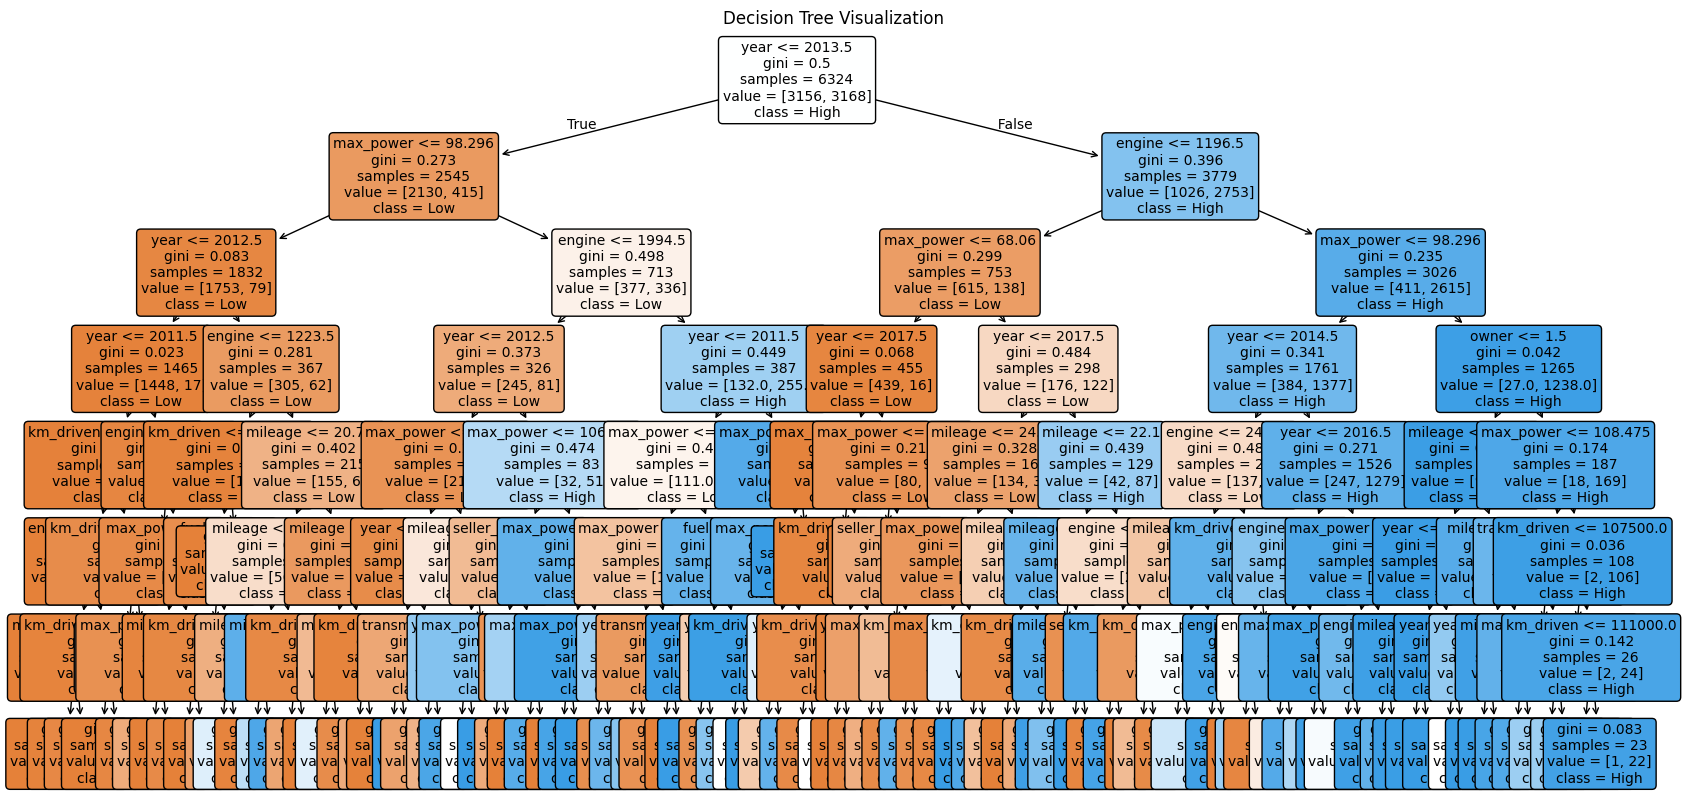

In [177]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_grid.best_estimator_, feature_names=X.columns, class_names=['Low', 'High'], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

In [178]:
# Clustering: K-Means with Hyperparameter Tuning
best_score = -1
best_kmeans_model = None
for n_clusters in range(3, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=300).fit(X)
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg}")
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_kmeans_model = kmeans

print(f"Best n_clusters = {best_kmeans_model.n_clusters}, Best silhouette_score = {best_score}")

For n_clusters = 3, The average silhouette_score is: 0.5840929042770944
For n_clusters = 4, The average silhouette_score is: 0.5833774992159003
For n_clusters = 5, The average silhouette_score is: 0.5704274096460286
For n_clusters = 6, The average silhouette_score is: 0.5703100950775585
For n_clusters = 7, The average silhouette_score is: 0.5452502199148416
For n_clusters = 8, The average silhouette_score is: 0.5586173776470037
For n_clusters = 9, The average silhouette_score is: 0.5524352019169698
For n_clusters = 10, The average silhouette_score is: 0.5423072184743514
Best n_clusters = 3, Best silhouette_score = 0.5840929042770944


C:\Users\ccoos\AppData\Local\Temp\ipykernel_23704\4129315375.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], label=f"Cluster {cluster_label}", c=plt.cm.viridis(cluster_label / best_kmeans_model.n_clusters))


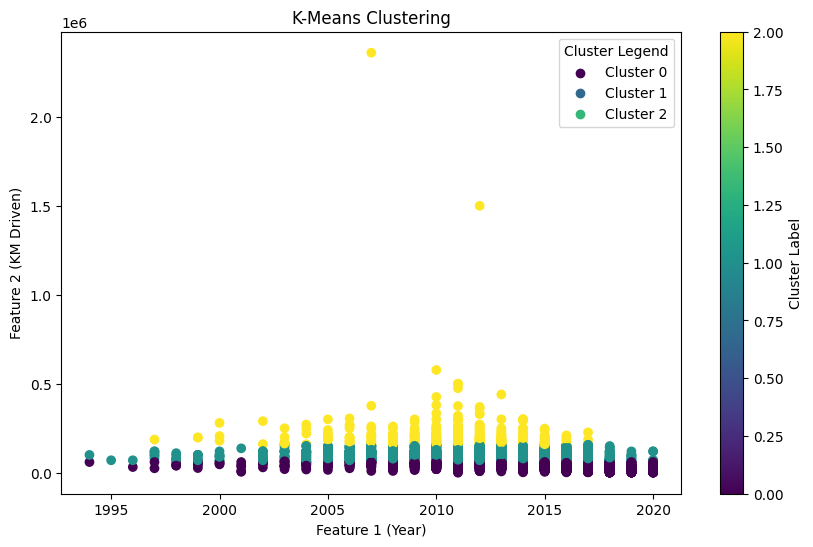

In [179]:
# Visualize the best K-Means
clusters = best_kmeans_model.labels_
plt.figure(figsize=(10, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster Label')
plt.title("K-Means Clustering")
plt.xlabel("Feature 1 (Year)")
plt.ylabel("Feature 2 (KM Driven)")
for cluster_label in np.unique(clusters):
    plt.scatter([], [], label=f"Cluster {cluster_label}", c=plt.cm.viridis(cluster_label / best_kmeans_model.n_clusters))
plt.legend(title="Cluster Legend", loc="upper right")
plt.show()
